In [ ]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from functorch import make_functional

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

batch_size = 4

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


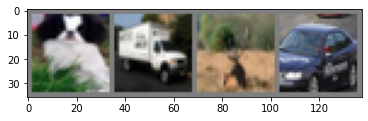

dog   truck deer  car  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Stateful PyTorch

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.149
[1,  4000] loss: 1.795
[1,  6000] loss: 1.647
[1,  8000] loss: 1.560
[1, 10000] loss: 1.478
[1, 12000] loss: 1.421
[2,  2000] loss: 1.360
[2,  4000] loss: 1.354
[2,  6000] loss: 1.307
[2,  8000] loss: 1.273
[2, 10000] loss: 1.286
[2, 12000] loss: 1.277
Finished Training


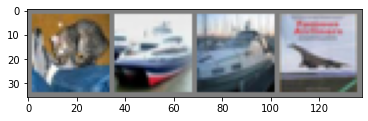

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Functional PyTorch

In [ ]:
def sgd_optimizer(weights, learning_rate):
    return [weight - learning_rate * weight.grad for weight in weights]

In [ ]:
model = Classifier()
functional_model, weights = make_functional(model)
criterion = nn.CrossEntropyLoss()

In [ ]:
def functional_step(inputs, labels, weights):
    weights = [weight.detach().requires_grad_() for weight in weights]
    outputs = functional_model(weights, inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    new_weights = sgd_optimizer(weights, 1e-3)
    return loss, new_weights

In [ ]:
def train(train_step_fn, weights):
    running_loss = 0.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        train_step_fn(inputs, labels, weights)
        loss, weights = train_step_fn(inputs, labels, weights)
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    return running_loss, weights

In [ ]:
for epoch in range(2):
    loss, weights = train(functional_step, weights)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.303
[1,  6000] loss: 2.301
[1,  8000] loss: 2.299
[1, 10000] loss: 2.295
[1, 12000] loss: 2.285
[2,  2000] loss: 2.235
[2,  4000] loss: 2.133
[2,  6000] loss: 2.053
[2,  8000] loss: 1.989
[2, 10000] loss: 1.951
[2, 12000] loss: 1.889


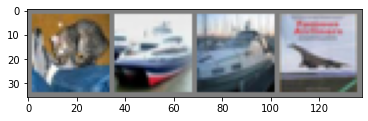

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))